In [1]:
!pip install -q pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.3 MB/s eta 0:00:00:00:010:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import pickle
import scipy.stats as stats
import pycountry
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy import stats
import scipy
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tools import add_constant
from collections import defaultdict, Counter
from itertools import chain, combinations
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import PercentFormatter

In [3]:
import matplotlib
matplotlib.rcParams['font.size'] = 30

### Regional Data & Statistics

In [4]:
regions = {
    'Middle East': ['AE', 'BH', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'QA', 'SA', 'YE'],
    'North Africa': ['DZ', 'EG', 'LY', 'MA', 'TN'],
    'North America': ['CA', 'US'],
    'South Asia': ['BD', 'IN', 'LK', 'NP', 'PK'],
    'Caribbean': ['JM', 'PR', 'DO'],
    'Southeast Asia': ['ID', 'KH', 'LA', 'MY', 'PH', 'SG', 'TH', 'VN'],
    'East Asia': ['HK', 'JP', 'KR', 'MN', 'TW'],
    'Europe': ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 
               'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI', 'LT', 'LU', 
               'LV', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 
               'SE', 'SI', 'SK', 'UA'],
    'Latin America': ['AR', 'BO', 'BR', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'HN', 'MX', 
                     'NI', 'PA', 'PE', 'PR', 'PY', 'SV', 'UY', 'VE'],
    'Sub-Saharan Africa': ['GH', 'KE', 'NG', 'SN', 'TZ', 'UG', 'ZA', 'ZW'],
    'Oceania': ['AU', 'NZ', 'PG'],
    'Central Asia': ['AM', 'AZ', 'GE', 'KZ'],
}

hdi_index_by_country = {
    'US': 0.927,  # United States
    #'BY': 0.801,  # Belarus
    'RS': 0.805,  # Serbia
    'LK': 0.780,  # Sri Lanka
    'DE': 0.950,  # Germany
    'KW': 0.847,  # Kuwait
    'BH': 0.888,  # Bahrain
    'MY': 0.807,  # Malaysia
    'PE': 0.762,  # Peru
    'KH': 0.600,  # Cambodia
    'ZW': 0.550,  # Zimbabwe (updated)
    'DO': 0.766,  # Dominican Republic
    'LU': 0.927,  # Luxembourg
    'RO': 0.827,  # Romania
    'EE': 0.899,  # Estonia
    'AU': 0.946,  # Australia
    'CA': 0.935,  # Canada
    'PK': 0.540,  # Pakistan (updated)
    'QA': 0.875,  # Qatar
    'BD': 0.670,  # Bangladesh
    'TH': 0.803,  # Thailand
    'EG': 0.728,  # Egypt
    'AL': 0.789,  # Albania
    'MA': 0.698,  # Morocco
    'UA': 0.734,  # Ukraine
    'TN': 0.732,  # Tunisia
    'FR': 0.910,  # France
    'DZ': 0.745,  # Algeria
    'LA': 0.620,  # Lao PDR
    'AM': 0.786,  # Armenia
    'YE': 0.424,  # Yemen (updated)
    'AZ': 0.760,  # Azerbaijan
    'ZA': 0.717,  # South Africa
    'UG': 0.550,  # Uganda (updated)
    'HN': 0.624,  # Honduras
    'CY': 0.907,  # Cyprus
    'PY': 0.731,  # Paraguay
    'BO': 0.698,  # Bolivia
    'KZ': 0.802,  # Kazakhstan
    'MD': 0.763,  # Moldova
    'LY': 0.746,  # Libya
    'VE': 0.699,  # Venezuela
    'MK': 0.765,  # North Macedonia
    'IS': 0.959,  # Iceland
    'ES': 0.911,  # Spain
    'CH': 0.967,  # Switzerland
    'ME': 0.844,  # Montenegro
    'JP': 0.920,  # Japan
    'KR': 0.929,  # Korea, Republic of
    'CZ': 0.895,  # Czech Republic
    'PR': None,   # Puerto Rico (no data provided)
    'HR': 0.878,  # Croatia
    'GT': 0.629,  # Guatemala
    'DK': 0.952,  # Denmark
    'SN': 0.517,  # Senegal (updated)
    'IL': 0.915,  # Israel
    'AR': 0.849,  # Argentina
    'SK': 0.855,  # Slovakia
    'HK': 0.956,  # Hong Kong
    'GH': 0.602,  # Ghana
    'ID': 0.713,  # Indonesia
    'HU': 0.851,  # Hungary
    'NP': 0.601,  # Nepal
    'GR': 0.893,  # Greece
    'MX': 0.781,  # Mexico
    'MN': 0.741,  # Mongolia
    'RU': 0.821,  # Russian Federation
    'LB': 0.723,  # Lebanon
    'BG': 0.799,  # Bulgaria
    'TW': 0.916,   # Taiwan (no data provided)
    'IE': 0.950,  # Ireland
    'PT': 0.874,  # Portugal
    'PA': 0.820,  # Panama
    'JO': 0.736,  # Jordan
    'NI': 0.669,  # Nicaragua
    'PH': 0.710,  # Philippines
    'NL': 0.946,  # Netherlands
    'PL': 0.881,  # Poland
    'LV': 0.879,  # Latvia
    'SG': 0.949,  # Singapore
    'IQ': 0.673,  # Iraq
    'EC': 0.765,  # Ecuador
    'SV': 0.674,  # El Salvador
    'CL': 0.860,  # Chile
    'LI': 0.942,  # Liechtenstein
    'BR': 0.760,  # Brazil
    'MT': 0.915,  # Malta
    'JM': 0.706,  # Jamaica
    'SE': 0.952,  # Sweden
    'TZ': 0.532,  # Tanzania (updated)
    #'TR': 0.855,  # Turkey
    'CR': 0.806,  # Costa Rica
    'FI': 0.942,  # Finland
    'GE': 0.814,  # Georgia
    'SA': 0.875,  # Saudi Arabia
    'PG': 0.568,  # Papua New Guinea (updated)
    'IN': 0.644,  # India
    'LT': 0.879,  # Lithuania
    'VN': 0.726,  # Vietnam
    'IT': 0.906,  # Italy
    'NZ': 0.939,  # New Zealand
    'AT': 0.926,  # Austria
    'AE': 0.937,  # United Arab Emirates
    'UY': 0.830,  # Uruguay
    'CO': 0.758,  # Colombia
    'KE': 0.601,  # Kenya
    'SI': 0.926,  # Slovenia
    'NG': 0.548,  # Nigeria (updated)
    'GB': 0.940,  # United Kingdom
    'BE': 0.942,  # Belgium
    'BA': 0.779,  # Bosnia and Herzegovina
    'OM': 0.819,  # Oman
    'NO': 0.966   # Norway
}

country_languages_official = {
    'AL': ['sq'], 'AT': ['de-AT'], 'BA': ['bs', 'hr', 'sr-Cyrl', 'sr-Latn'], 'BE': ['nl-BE', 'fr-BE', 'de-BE'],
    'BG': ['bg'], 'CY': ['el', 'tr'], 'CZ': ['cs'], 'DE': ['de-DE'], 'DK': ['da'], 'EE': ['et'], 'ES': ['es-ES'],
    'FI': ['fi', 'sv'], 'FR': ['fr-FR'], 'GB': ['en-GB'], 'GR': ['el'], 'HR': ['hr'], 'HU': ['hu'], 'IE': ['en-IE', 'ga'],
    'IS': ['is'], 'IT': ['it'], 'LT': ['lt'], 'LU': ['lb', 'fr-LU', 'de-LU'], 'LV': ['lv'], 'ME': ['sr-Cyrl', 'sr-Latn'],
    'MK': ['mk'], 'NL': ['nl-NL'], 'PL': ['pl'], 'PT': ['pt-PT'], 'RO': ['ro'], 'RS': ['sr-Cyrl', 'sr-Latn'], 'RU': ['ru'],
    'SE': ['sv'], 'SI': ['sl'], 'SK': ['sk'], 'UA': ['uk']
}

country_languages_widely_spoken = {
    'AL': ['sq', 'it'], 'AT': ['de-AT', 'en-GB'], 'BA': ['bs', 'hr', 'sr-Cyrl', 'sr-Latn'], 'BE': ['nl-BE', 'fr-BE', 'de-BE', 'en-GB'],
    'BG': ['bg', 'ru'], 'CY': ['el', 'tr', 'en-GB'], 'CZ': ['cs', 'de-DE', 'en-GB'], 'DE': ['de-DE', 'en-GB', 'tr'], 'DK': ['da', 'en-GB'],
    'EE': ['et', 'ru'], 'ES': ['es-ES', 'en-GB', 'ca'], 'FI': ['fi', 'sv', 'en-GB'], 'FR': ['fr-FR', 'en-GB'], 'GB': ['en-GB'],
    'GR': ['el', 'en-GB'], 'HR': ['hr', 'en-GB'], 'HU': ['hu', 'en-GB'], 'IE': ['en-IE', 'ga'], 'IS': ['is', 'en-GB'],
    'IT': ['it', 'en-GB'], 'LT': ['lt', 'ru'], 'LU': ['lb', 'fr-LU', 'de-LU', 'en-GB'], 'LV': ['lv', 'ru'], 'ME': ['sr-Cyrl', 'sr-Latn', 'ru'],
    'MK': ['mk', 'bg', 'sr-Cyrl', 'sr-Latn'], 'NL': ['nl-NL', 'en-GB'], 'PL': ['pl', 'de-DE', 'en-GB'], 'PT': ['pt-PT', 'en-GB'],
    'RO': ['ro', 'en-GB'], 'RS': ['sr-Cyrl', 'sr-Latn', 'ru'], 'RU': ['ru'], 'SE': ['sv', 'en-GB'], 'SI': ['sl', 'en-GB'], 'SK': ['sk', 'hu', 'en-GB'],
    'UA': ['uk', 'ru']
}

catid2str = {
    2 : 'Autos & Vehicles',
    1 :  'Film & Animation',
    10 : 'Music',
    15 : 'Pets & Animals',
    17 : 'Sports',
    18 : 'Short Movies',
    19 : 'Travel & Events',
    20 : 'Gaming',
    21 : 'Videoblogging',
    22 : 'People & Blogs',
    23 : 'Comedy',
    24 : 'Entertainment',
    25 : 'News & Politics',
    26 : 'Howto & Style',
    27 : 'Education',
    28 : 'Science & Technology',
    29 : 'Nonprofits & Activism',
    30 : 'Movies',
    31 : 'Anime/Animation',
    32 : 'Action/Adventure',
    33 : 'Classics',
    34 : 'Comedy',
    35 : 'Documentary',
    36 : 'Drama',
    37 : 'Family',
    38 : 'Foreign',
    39 : 'Horror',
    40 : 'Sci-Fi/Fantasy',
    41 : 'Thriller',
    42 : 'Shorts',
    43 : 'Shows',
    44 : 'Trailers'
}
country_to_iso_regions = {
    'Europe' : {
        'AL': 'ALB',  # Albania
        'AT': 'AUT',  # Austria
        'BA': 'BIH',  # Bosnia and Herzegovina
        'BE': 'BEL',  # Belgium
        'BG': 'BGR',  # Bulgaria
        'CH': 'CHE',  # Switzerland
        'CY': 'CYP',  # Cyprus
        'CZ': 'CZE',  # Czech Republic
        'DE': 'DEU',  # Germany
        'DK': 'DNK',  # Denmark
        'EE': 'EST',  # Estonia
        'ES': 'ESP',  # Spain
        'FI': 'FIN',  # Finland
        'FR': 'FRA',  # France
        'GB': 'GBR',  # United Kingdom
        'GR': 'GRC',  # Greece
        'HR': 'HRV',  # Croatia
        'HU': 'HUN',  # Hungary
        'IE': 'IRL',  # Ireland
        'IS': 'ISL',  # Iceland
        'IT': 'ITA',  # Italy
        'LI': 'LIE',  # Liechtenstein
        'LT': 'LTU',  # Lithuania
        'LU': 'LUX',  # Luxembourg
        'LV': 'LVA',  # Latvia
        'MD': 'MDA',  # Moldova
        'ME': 'MNE',  # Montenegro
        'MK': 'MKD',  # North Macedonia
        'MT': 'MLT',  # Malta
        'NL': 'NLD',  # Netherlands
        'NO': 'NOR',  # Norway
        'PL': 'POL',  # Poland
        'PT': 'PRT',  # Portugal
        'RO': 'ROU',  # Romania
        'RS': 'SRB',  # Serbia
        'RU': 'RUS',  # Russia
        'SE': 'SWE',  # Sweden
        'SI': 'SVN',  # Slovenia
        'SK': 'SVK',  # Slovakia
        'UA': 'UKR'   # Ukraine
    },
    'Middle East' : {
        'AE': 'ARE',  # United Arab Emirates
        'BH': 'BHR',  # Bahrain
        'IQ': 'IRQ',  # Iraq
        'IL': 'ISR',  # Israel
        'JO': 'JOR',  # Jordan
        'KW': 'KWT',  # Kuwait
        'LB': 'LBN',  # Lebanon
        'OM': 'OMN',  # Oman
        'QA': 'QAT',  # Qatar
        'SA': 'SAU',  # Saudi Arabia
        'YE': 'YEM'   # Yemen
    },
    'North Africa': {
        'DZ': 'DZA',  # Algeria
        'EG': 'EGY',  # Egypt
        'LY': 'LBY',  # Libya
        'MA': 'MAR',  # Morocco
        'TN': 'TUN'   # Tunisia
    },
    'North America' : {
        'CA': 'CAN',  # Canada
        'US': 'USA'   # United States of America
    },
    'South Asia': {
    'BD': 'BGD',  # Bangladesh
    'IN': 'IND',  # India
    'LK': 'LKA',  # Sri Lanka
    'NP': 'NPL',  # Nepal
    'PK': 'PAK'   # Pakistan
},
'Caribbean':{
    'JM': 'JAM',  # Jamaica
    'PR': 'PRI',  # Puerto Rico
    'DO': 'DOM'   # Dominican Republic
},
'Southeast Asia': {
    'ID': 'IDN',  # Indonesia
    'KH': 'KHM',  # Cambodia
    'LA': 'LAO',  # Laos
    'MY': 'MYS',  # Malaysia
    'PH': 'PHL',  # Philippines
    'SG': 'SGP',  # Singapore
    'TH': 'THA',  # Thailand
    'VN': 'VNM'   # Vietnam
},
'East Asia': {
    'HK': 'HKG',  # Hong Kong
    'JP': 'JPN',  # Japan
    'KR': 'KOR',  # South Korea
    'MN': 'MNG',  # Mongolia
    'TW': 'TWN'   # Taiwan
},
'Latin America':{
    'AR': 'ARG',  # Argentina
    'BO': 'BOL',  # Bolivia
    'BR': 'BRA',  # Brazil
    'CL': 'CHL',  # Chile
    'CO': 'COL',  # Colombia
    'CR': 'CRI',  # Costa Rica
    'DO': 'DOM',  # Dominican Republic
    'EC': 'ECU',  # Ecuador
    'GT': 'GTM',  # Guatemala
    'HN': 'HND',  # Honduras
    'MX': 'MEX',  # Mexico
    'NI': 'NIC',  # Nicaragua
    'PA': 'PAN',  # Panama
    'PE': 'PER',  # Peru
    'PR': 'PRI',  # Puerto Rico
    'PY': 'PRY',  # Paraguay
    'SV': 'SLV',  # El Salvador
    'UY': 'URY',  # Uruguay
    'VE': 'VEN'   # Venezuela
},
'Sub-Saharan Africa':{
    'GH': 'GHA',  # Ghana
    'KE': 'KEN',  # Kenya
    'NG': 'NGA',  # Nigeria
    'SN': 'SEN',  # Senegal
    'TZ': 'TZA',  # Tanzania
    'UG': 'UGA',  # Uganda
    'ZA': 'ZAF',  # South Africa
    'ZW': 'ZWE'   # Zimbabwe
},
'Oceania':{
    'AU': 'AUS',  # Australia
    'NZ': 'NZL',  # New Zealand
    'PG': 'PNG'   # Papua New Guinea
},
'Central Asia': {
    'AM': 'ARM',  # Armenia
    'AZ': 'AZE',  # Azerbaijan
    'GE': 'GEO',  # Georgia
    'KZ': 'KAZ'   # Kazakhstan
}    
}

### Data Loading

In [5]:
def filter_dataframe(df):
    return df.query("view_count < 0.5e9 and days_after_pub_to_first_trend >= 0").reset_index(drop=True)

def load_country_data(country_code):
    """Load data for a specific country and return emoji usage statistics"""
    try:
        df = pd.read_csv(f"/kaggle/input/youtube-daily-trendings-with-features/dataset_with_features_{country_code}.csv")
        df = filter_dataframe(df)
        return df
    except FileNotFoundError:
        print(f"No data found for {country_code}")
        return None
full_dataset_by_country = {}
for region in tqdm(regions):
    for country_code in regions[region]:
        df = load_country_data(country_code)
        full_dataset_by_country[country_code] = (df.iloc[df['video_id'].drop_duplicates().index]).reset_index(drop=True)

  0%|          | 0/12 [00:00<?, ?it/s]


No data found for AE


AttributeError: 'NoneType' object has no attribute 'iloc'

# 4. Explore categories across the countries

Goal:

We want to understand and compare the popularity of different content categories across countries. Essentially, we are trying to discover which types of content are most common in each region and whether these trends differ significantly between countries.

In [36]:
def load_video_categories(file_path):
    """Load video categories with consistency checks."""
    categories = pd.read_csv(file_path)
    
    video_categories = (
        categories[['video_id', 'category_id']]
        .dropna(subset=['category_id'])
        .drop_duplicates(subset=['video_id'], keep='first')
    )
    
    return video_categories.set_index('video_id')['category_id'].astype(int).to_dict()

video2cat = load_video_categories('/kaggle/input/youtube-channel-info/unique_videos_with_category.csv')

def process_channel_categories(full_dataset):
    """Aggregate video categories per channel using vectorized operations."""
    all_data = pd.concat([
        df[['channel_id', 'video_id']] 
        for df in full_dataset.values()
    ])

    merged = all_data.merge(
        pd.Series(video2cat, name='category_id').reset_index().rename(columns={'index': 'video_id'}),
        on='video_id',
        how='inner'
    )
    
    channel_categories = merged.groupby('channel_id')['category_id'].agg(set)
    return channel_categories.to_dict()

channel_to_trending_videos = process_channel_categories(full_dataset_by_country)

In [37]:
def get_modal_category(categories):
    """Safely calculate mode of categories."""
    return stats.mode(list(categories)).mode

channel_to_trending_videos = {
    channel: get_modal_category(cats)
    for channel, cats in tqdm(channel_to_trending_videos.items(),
                             desc="Calculating modes")
}

Calculating modes: 100%|██████████| 34382/34382 [00:12<00:00, 2713.66it/s]


In [38]:
def load_country_mapping(file_path, channel_data):
    """Load country mapping with missing channel tracking."""
    with open(file_path, 'rb') as f:
        channel_to_country = pickle.load(f)
    
    country_map = defaultdict(list)
    missed = []
    
    for channel, country in tqdm(channel_to_country.items(),
        desc="Mapping countries"):
        if channel in channel_data:
            if (category := channel_data[channel]) is not None:
                country_map[country].append(category)
        else:
            missed.append(channel)
    return dict(country_map), missed

country2channelcat, missed_channels = load_country_mapping('dat/channel_countries.pickle', channel_to_trending_videos)

Mapping countries: 100%|██████████| 35123/35123 [00:00<00:00, 909625.26it/s]


In [39]:
def get_unique_cats(country2channelcat):
    all_categories = list(chain.from_iterable(country2channelcat.values()))
    unique_categories = np.unique(all_categories)
    return unique_categories
USED_CATS = get_unique_cats(country2channelcat)

<ipython-input-40-4e4499e4606c>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_mask = df.applymap(lambda x: x > 0.05)


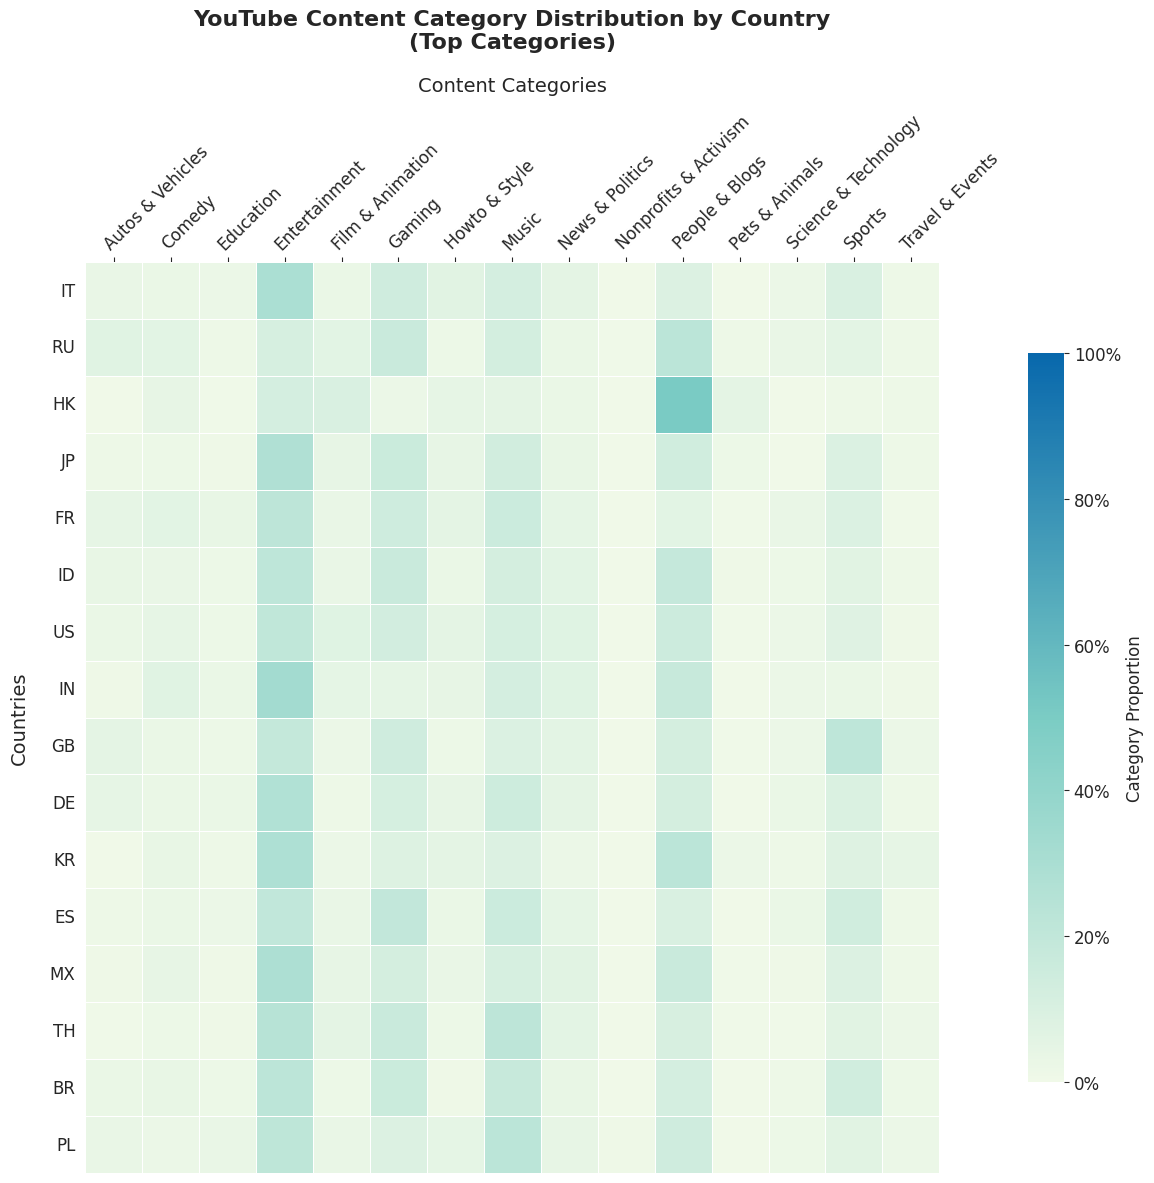

In [40]:
# 1. Create category mapping more efficiently
used_categories = [c for c in catid2str if c in USED_CATS]
catid2vecpos = {cat_id: idx for idx, cat_id in enumerate(sorted(used_categories, key=lambda x: catid2str[x]))}

# 2. Optimized country distribution calculation
country_to_topic_distr = defaultdict(lambda: np.zeros(len(catid2vecpos)))
grand_total=0
for country, categories in country2channelcat.items():
    if country is None or len(categories) <=500:
        continue
    
    # Vectorized counting using numpy
    unique, counts = np.unique(categories, return_counts=True)
    for cat_id, count in zip(unique, counts):
        if cat_id in catid2vecpos:
            country_to_topic_distr[country][catid2vecpos[cat_id]] = count
            grand_total += count
print(f"\nGrand Total Videos: {grand_total}")

# 3. Create DataFrame more efficiently
df = pd.DataFrame.from_dict(
    {country: dist/dist.sum() for country, dist in country_to_topic_distr.items()},
    orient='index'
)

# Create meaningful column names
df.columns = [catid2str[cat_id] for cat_id in sorted(catid2vecpos, key=lambda x: catid2vecpos[x])]



def heat_map(local_df,text):
    local_df = local_df.sort_index(axis=1)
    local_df = local_df.sort_index(axis=0)
    # Find actual maximum proportion in the data
    data_max = 0.51 # local_df.values.max()

    print("\nCountry codes:", local_df.index.tolist())
    
    # 4. Improved visualization parameters
    plt.figure(figsize=(6, 6))
    #plt.rcParams.update({'font.size': 12})

    # Create custom colormap with better perceptual uniformity
    colors = ["#f0f9e8", "#7bccc4", "#0868ac"]
    cmap = LinearSegmentedColormap.from_list("custom_div", colors, N=256)

    # Create annotation mask for better readability
    #annotation_mask = df.applymap(lambda x: x > 0.05)  # Only annotate values > 5%     
    ax = sns.heatmap(
        local_df,
        cmap=cmap,
        annot=False,
        fmt=".1%",
        annot_kws={'size': 10},
        linewidths=0.5,
        linecolor='white',
        cbar_kws={
            'label': 'Category Proportion per Country',
            'ticks': np.linspace(0, data_max, 6),
            'format': PercentFormatter(xmax=1.0, decimals=0),
            'shrink': 0.8
        },
        square=True,
        vmin=0,
        vmax=data_max  # Set vmax to actual data maximum
    )

    # 5. Enhanced visualization styling
    #ax.set_title("YouTube Content Category Distribution\n by Country "+text, fontsize=16, pad=20, fontweight='semibold')
    ax.set_xlabel("Content Categories", labelpad=15, fontsize=14)
    ax.set_ylabel("Countries", labelpad=15, fontsize=14)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # Rotate labels and adjust alignment
    plt.xticks(rotation=45, ha='left', rotation_mode='anchor', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)

    # Add grid lines for better readability
    ax.vlines(np.arange(len(local_df.columns)), 0, len(local_df), colors='white', linewidths=0.5)
    ax.hlines(np.arange(len(local_df.index)), 0, len(local_df.columns), colors='white', linewidths=0.5)

    # Adjust colorbar
    # cbar = ax.collections[0].colorbar
    # cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    plt.tight_layout()
    plt.savefig('YT_Category_Distribution_by_Country '+text+'.png', dpi=600, bbox_inches='tight')  # Save as PNG with high resolution
    plt.show()




In [ ]:
# Directory containing the input files
input_dir = 'kaggle\\youtube-daily-trendings-with-features'

# List to hold individual DataFrames
dataframes = []

import os
# Loop through the files and read them
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(input_dir, filename)
        df2 = pd.read_csv(file_path)
        df2['source_file'] = filename  # Optional: Add a column to identify the source file
        dataframes.append(df2)

# Concatenate all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df = combined_df[['video_id', 'title','country','channel_name','channel_id','publish_date','snapshot_date']].drop_duplicates()
print(f"Combined DataFrame shape: {combined_df.shape}")

unfiltered_merged = combined_df[['video_id', 'title','country','channel_name','channel_id','publish_date','snapshot_date']].merge(
        pd.Series(video2cat, name='category_id').reset_index().rename(columns={'index': 'video_id'}),
        on='video_id',
        how='inner'
    )

print("unfiltered_merged.shape",unfiltered_merged.shape)


In [ ]:
#filter for year 2024
unfiltered_merged = unfiltered_merged[pd.to_datetime(unfiltered_merged['snapshot_date']).dt.year == 2024]

unfiltered_counts = unfiltered_merged.groupby(['country', 'category_id']).size().reset_index(name='total_videos')
unfiltered_pivot = unfiltered_counts.pivot(index='country', columns='category_id', values='total_videos').fillna(0)

selected_countries = ['IT', 'RU', 'HK', 'JP', 'FR', 'ID', 'US', 'IN', 'GB', 'DE', 'KR', 'ES', 'MX', 'TH', 'BR', 'PL']
print("\nCountry codes:", unfiltered_pivot.index.tolist())
#selected_countries = ['GT', 'OM', 'BH', 'LU', 'ME', 'BO', 'MT', 'LY', 'MN', 'LA', 'CR', 'VE', 'CI', 'PY', 'RE', 'MD', 'HN', 'IS', 'RW', 'TC', 'BF', 'MM', 'MC', 'WS', 'SY', 'NI', 'NC', 'UZ', 'AG', 'BJ', 'PG', 'AM']
selected_countries = unfiltered_pivot.index.intersection(selected_countries)
unfiltered_pivot = unfiltered_pivot.loc[selected_countries]

unfiltered_pivot = unfiltered_pivot.rename(columns={
    'Unknown Category': 'Nonprofits & Activism'  #Nonprofits & Activism / Unknown Category
})


grand_total = unfiltered_pivot.values.sum()     # Total videos across all countries and categories
print(f"\nGrand Total Unfiltered Videos: {grand_total}")
# Normalize rows to get proportions
unfiltered_pivot = unfiltered_pivot.div(unfiltered_pivot.sum(axis=1), axis=0)  # Divide each row by its sum

# Create meaningful column names
unfiltered_pivot.columns = [catid2str[cat_id] for cat_id in unfiltered_pivot.columns]
heat_map(unfiltered_pivot,"with duplicates")
heat_map(df,"without duplicates")

In [41]:
def compare_category_proportions(
    country1: str,
    country2: str,
    category1_str: str,
    category2_str: str,
    country_to_categories: dict,
    str_to_category_id: dict,
    catid2vecpos: dict,
) -> tuple[float, float]:
    """
    Compare proportions of two categories between two countries using a z-test.
    
    Args:
        country1: Name of first country to compare
        country2: Name of second country to compare
        category1_str: Category name for first country's test
        category2_str: Category name for second country's test
        country_to_categories: Dictionary mapping countries to category lists
        str_to_category_id: Dictionary mapping category names to IDs
        catid2vecpos: Dictionary mapping category IDs to vector positions
        
    Returns:
        tuple: (z_score, p_value)
        The test evaluates H0: p_category1_country1 = p_category2_country2
                 against HA: p_category1_country1 < p_category2_country2
    """
    cat1_id = str_to_category_id[category1_str]
    cat2_id = str_to_category_id[category2_str]

    def get_country_data(country):
        return np.array(country_to_categories.get(country, []))
        
    country1_data = get_country_data(country1)
    country2_data = get_country_data(country2)
    count1 = country1_data[catid2vecpos[cat1_id]]
    count2 = country2_data[catid2vecpos[cat2_id]]
    nobs1 = sum(country1_data)
    nobs2 = sum(country2_data)

    zstat, pvalue = proportions_ztest(
        count=[count1, count2],
        nobs=[nobs1, nobs2],
        alternative='smaller',
        prop_var=False
    )

    return zstat, pvalue

In [42]:
str_to_category_id = {catid2str[k] : k for k in USED_CATS}

In [43]:
compare_category_proportions('DE', 'RU', 'Comedy', 'Comedy', country_to_topic_distr, str_to_category_id, catid2vecpos)
# Means that comedy is more popular in Russia as we use Bonferoni

(-4.630459077190578, 1.8242794506817324e-06)

In [44]:
compare_category_proportions('BR', 'GB', 'Sports', 'Sports', country_to_topic_distr, str_to_category_id, catid2vecpos)
# Means that Sports is more popular in GB as we use Bonferoni

(-4.715565468470102, 1.205201851240021e-06)

In [45]:
compare_category_proportions('US', 'DE', 'Autos & Vehicles', 'Sports', country_to_topic_distr, str_to_category_id, catid2vecpos)
# Means that Autos in DE are more popular than Sports in the US as we use Bonferoni

(-11.843736241410618, 1.1594376722372352e-32)

In [ ]:
compare_category_proportions('DE', 'HK', 'People & Blogs', 'People & Blogs', country_to_topic_distr, str_to_category_id, catid2vecpos)
